# Использование CV модел ResNet50 для определения возраста покупателей 

**Описание проекта:**
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:**
Построить модель, которая по фотографии определит приблизительный возраст человека.

**План работ:**
- Проведение исследовательского анализа набора фотографий.
- Подготовка данных к обучению.
- Обучение нейронную сеть и рассчет её качества.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

from PIL import Image

## Исследовательский анализ данных

In [2]:
try:
    data = pd.read_csv('/datasets/faces/labels.csv')
except:
    try:
        data = pd.read_csv('labels.csv')
    except:
        print('Something is wrong')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
# Размер выборки
data.shape

(7591, 2)

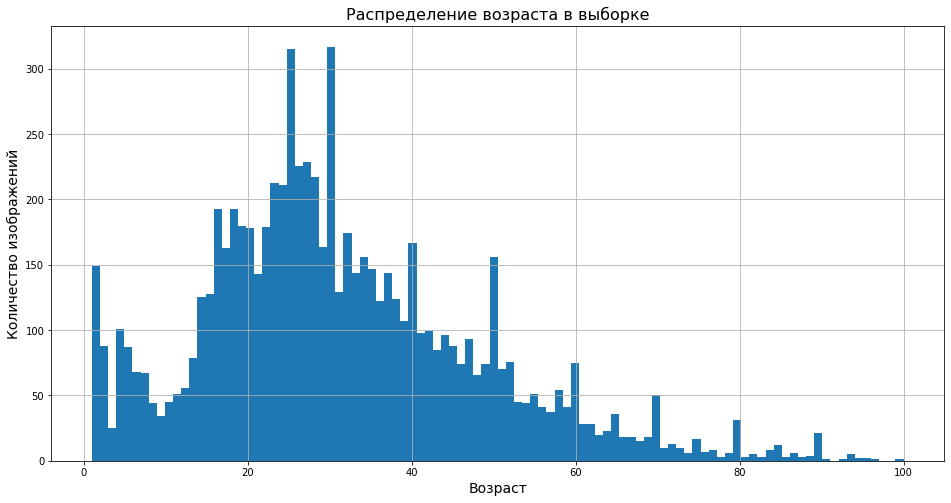

In [13]:
# График распределения возраста в выборке.
data.hist(bins=100, figsize=(16,8 ))
plt.title('Распределение возраста в выборке', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество изображений', fontsize=14)
plt.show()

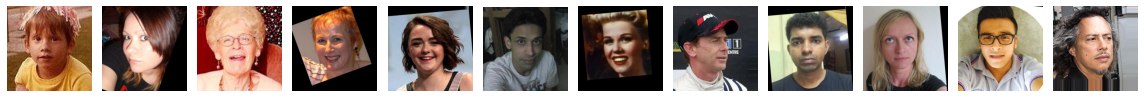

In [15]:
fig, axes = plt.subplots(1, 12, figsize=(16, 8))
for i in range(0, 12):
    if i < 10: file = f'/datasets/faces/final_files/00000{str(i)}.jpg'
    else: file = f'/datasets/faces/final_files/0000{str(i)}.jpg'
    
    image = Image.open(file)
    array = np.array(image)
    axes[i].imshow(array)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Выводы:**

- Размер выборки: Датасет содержит 7591 запись, каждая из которых включает два столбца: один столбец с именем файла изображения и другой с реальным возрастом человека на изображении.

- Распределение возраста: Гистограмма возрастов показывает, что большая часть выборки состоит из молодых людей и детей, особенно в диапазоне от 0 до 30 лет. Начиная с 30 лет, распределение становится менее плотным, а после 50 лет количесвто людей значительно уменьшается.

- Фотографии: люди на них расположены почти вертикально и занимают большую часть кадра, следовательно, повороты не требуются. Все фотографии цветные и имеют разный размер.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50


# Функция загрузки тренировочных данных
def load_train(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',  
        subset='training',
        seed=12345)
    return train_datagen_flow

# Функция загрузки тестовых данных
def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',  
        subset='validation',
        seed=12345)
    return test_datagen_flow

# Функция создания модели
def create_model(input_shape):
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1)) 

    optimizer=Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-10-23 18:22:55.260074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-23 18:22:55.618071: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 59s - loss: 219.8333 - mae: 10.8615 - val_loss: 666.4340 - val_mae: 20.8207
Epoch 2/5
356/356 - 43s - loss: 70.8212 - mae: 6.4205 - val_loss: 179.4469 - val_mae: 10.0956
Epoch 3/5
356/356 - 43s - loss: 38.1867 - mae: 4.7772 - val_loss: 78.3364 - val_mae: 6.6503
Epoch 4/5
356/356 - 43s - loss: 24.4344 - mae: 3.8244 - val_loss: 88.5307 - val_mae: 6.9197
Epoch 5/5
356/356 - 43s - loss: 16.9150 - mae: 3.1279 - val_loss: 73.6565 - val_mae: 6.5286
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 73.6565 - mae: 6.5286
```

## Анализ обученной модели

- Модель: была использована архитектура ResNet50, которая была предварительно обучена на большом наборе данных ImageNet. Исходные полносвязные слои были заменены для нашей задачи. На выходе добавлен слой GlobalAveragePooling2D, который сглаживает выходные данные сверточных слоев, и затем один полносвязный слой с одним нейроном для предсказания возраста.
    - Функция потерь: MSE
    - Метрика: MAE 
    - Оптимизатор: Adam (lr = 0.0001)


- Модель достигла MAE = 6.53 на валидационной выборке. Целевое значение MAE меньше 8 было достигнуто, и результат близок к эталонному значению в 5.4, описанному в статье о датасете.
- Модель не переобучилась, так как разница между MAE на тренировочной и валидационной выборках относительно небольшая (3.13 и 6.53 соответственно).
- В целом, модель ResNet50 с минимальными изменениями подходит для задач предсказания возраста.